# Transient Fickian Diffusion
The package `OpenPNM` allows for the simulation of many transport phenomena in porous media such as Stokes flow, Fickian diffusion, advection-diffusion, transport of charged species, etc. Transient and steady-state simulations are both supported. An example of a transient Fickian diffusion simulation through a `Cubic` pore network is shown here.

First, `OpenPNM` is imported.

In [1]:
import numpy as np
import openpnm as op
%config InlineBackend.figure_formats = ['svg']
np.random.seed(10)
%matplotlib inline
np.set_printoptions(precision=5)

## Fetch the global workspace
`Workspace` is `OpenPNM`'s global object manager. In simple terms, every object that you create (ex. networks, phases, and algorithms) can be ultimately found by inspecting the `Workspace`. Note that the `Workspace` object is a singleton, meaning that no matter how many times you instantiate it, you'll get one and only one instance back.

In [2]:
ws = op.Workspace()
ws.settings["loglevel"] = 40

## Generate a pore network
An arbitrary `Cubic` 3D pore network is generated consisting of a layer of $29\times13$ pores with a constant pore to pore centers spacing of ${10}^{-4}{m}$.

In [3]:
shape = [13, 29, 1]
net = op.network.Cubic(shape=shape, spacing=1e-4)

## Add geometrical properties
Initially, the `Cubic` class mostly has topological information plus the pore coordinates, and geometrical information such as pore diameter, throat diameter, etc. still needs to be added. `OpenPNM` has a rich library of models that add such information to your network, which are located under the `opepnm.models` module. Since you need to manually add many of these models for your simulation to work, `OpenPNM` provides "model collections", which can be added to your network in one shot. A model collection is a bundle of compatible models that together approximate a specific geometry, for instance `spheres_and_cylinders`, which assumes your pores are ideal spheres and the connecting throats are ideal cylinders. Model collections are located under `openpnm.collections`. Note that it's good practice to regenerate the models after you add a model collection.

In [4]:
mods = op.models.collections.geometry.spheres_and_cylinders()
net.add_model_collection(mods)
net.regenerate_models()

## Add a phase
Then, a phase (water in this example) is added to the simulation and assigned to the network. The phase contains the physical properties of the fluid considered in the simulation such as the viscosity, etc. Many predefined phases as available on `OpenPNM`.

In [5]:
water = op.phase.Water(network=net)

## Add geometry-based thermophysical properties
Like `Cubic`, initially the `Water` class only contains thermophysical properties, such as viscosity, molecular weight, etc. However, for your simulations to work, you need another set of properties such as diffusive conductance (to perform diffusion simulations), hydraulic conductance (to perform fluid flow simulations), etc. These properties, which we call geometry-based thermophysical properties, depend on both thermophysical and geometrical features. `OpenPNM` has lots of built-in geometry-based thermophysical properties, which are located under `openpnm.models.physics`. Similar to geometrical properties, `OpenPNM` provides various "model collections", which can be added to your `Phase` object in one shot, rather than adding different models one by one.

In [6]:
mods = op.models.collections.physics.basic()
water.add_model_collection(mods)
water.regenerate_models()

## Define a transient Fickian diffusion algorithm
Here, an algorithm for the simulation of transient Fickian diffusion is defined. It is assigned to the network and phase of interest to be able to retrieve all the information needed to build systems of linear equations.

In [7]:
tfd = op.algorithms.TransientFickianDiffusion(network=net, phase=water)

## Add boundary conditions
Next, Dirichlet boundary conditions are added over the back and front boundaries of the network.

In [8]:
tfd.set_value_BC(pores=net.pores('back'), values=0.5)
tfd.set_value_BC(pores=net.pores('front'), values=0.2)

## Define initial conditions
Initial conditions must be specified when `alg.run` is called as `alg.run(x0=x0)`, where `x0` could either be a scalar (in which case it'll be broadcasted to all pores), or an array.

## Setup the transient algorithm settings
The settings of the transient algorithm are updated here. When calling `alg.run`, you can pass the following arguments:
- `x0`: initial conditions
- `tspan`: integration time span
- `saveat`: the interval at which the solution is to be stored

In [9]:
x0 = 0.2
tspan = (0, 100)
saveat = 5

## Print the algorithm settings
One can print the algorithm's settings as shown here.

In [10]:
print(tfd.settings)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Settings                            Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
uuid                                41cd2a5e-02b4-4118-8d11-ae83183ec0a9
cache                               True
conductance                         throat.diffusive_conductance
phase                               phase_01
quantity                            pore.concentration
variable_props                      TypedSet()
f_rtol                              1e-06
newton_maxiter                      5000
relaxation_factor                   1.0
x_rtol                              1e-06
pore_volume                         pore.volume
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Note that the `quantity` corresponds to the quantity solved for.

## Run the algorithm
The algorithm is run here. Algorithms usually return the solution object, which is basically a dictionary containing the solution as a numpy array which can be accessed via the key `alg.settings.quantity`. In addition, the solution object is stored on the algorithm itself, so you can access it via `alg.soln`.

In [11]:
soln = tfd.run(x0=x0, tspan=tspan, saveat=saveat)

## Post process and export the results
Once the simulation is successfully performed. The solution at every time steps is stored within the algorithm object. The algorithm's stored information is printed here.

In [12]:
print(tfd)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
openpnm.algorithms.TransientFickianDiffusion : trans_fick_01
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Properties                                    Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.bc.rate                                      0 / 377  
2     pore.bc.value                                    26 / 377  
3     pore.concentration                              377 / 377  
4     pore.ic                                         377 / 377  
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Labels                                        Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.all                                      377       
2     pore.trans_fick_01                            377       
3     throat.all  

Note that the solution object contains the solution as a numpy array with the shape `[Np, nt]`, where `Np` and `nt` are the number of pores and exported time steps, respectively. For convenience, we've added some extra functionality to the numpy array, most notable of which is interpolation. So, if you want to interpolate the solution at some intermediate time point, you can just "call" the numpy array at that particular time point.

Let's take a look at the solution object.

In [13]:
x = soln["pore.concentration"]
print(soln)

{'pore.concentration': TransientSolution([[0.2    , 0.2    , 0.2    , ..., 0.2    , 0.2    ,
                    0.2    ],
                   [0.2    , 0.2    , 0.2    , ..., 0.2    , 0.2    ,
                    0.2    ],
                   [0.2    , 0.2    , 0.2    , ..., 0.2    , 0.2    ,
                    0.2    ],
                   ...,
                   [0.2    , 0.22296, 0.2528 , ..., 0.3612 , 0.36362,
                    0.36595],
                   [0.2    , 0.30164, 0.35183, ..., 0.43861, 0.43974,
                    0.44082],
                   [0.5    , 0.5    , 0.5    , ..., 0.5    , 0.5    ,
                    0.5    ]])}


To see which time points have been exported in the solution, object you can just look at its property `t`.

In [14]:
x.t

TransientSolution([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,
                    55,  60,  65,  70,  75,  80,  85,  90,  95, 100])

Now, let's interpolate the solution at some intermediate time point, `t = 7.34`.

In [15]:
x(7.34)

array([0.2    , 0.2    , 0.2    , 0.2    , 0.2    , 0.2    , 0.2    ,
       0.2    , 0.2    , 0.2    , 0.2    , 0.2    , 0.2    , 0.2    ,
       0.2    , 0.2    , 0.2    , 0.2    , 0.2    , 0.2    , 0.2    ,
       0.20001, 0.20003, 0.20017, 0.20151, 0.20712, 0.22662, 0.30658,
       0.5    , 0.2    , 0.2    , 0.2    , 0.2    , 0.2    , 0.2    ,
       0.2    , 0.2    , 0.2    , 0.2    , 0.2    , 0.2    , 0.2    ,
       0.2    , 0.2    , 0.2    , 0.2    , 0.2    , 0.2    , 0.2    ,
       0.2    , 0.2    , 0.20002, 0.20008, 0.20143, 0.20634, 0.21905,
       0.26123, 0.5    , 0.2    , 0.2    , 0.2    , 0.2    , 0.2    ,
       0.2    , 0.2    , 0.2    , 0.2    , 0.2    , 0.2    , 0.2    ,
       0.2    , 0.2    , 0.2    , 0.2    , 0.2    , 0.2    , 0.2    ,
       0.2    , 0.2    , 0.2    , 0.20002, 0.20012, 0.20064, 0.20532,
       0.22082, 0.317  , 0.5    , 0.2    , 0.2    , 0.2    , 0.2    ,
       0.2    , 0.2    , 0.2    , 0.2    , 0.2    , 0.2    , 0.2    ,
       0.2    , 0.2 

## Visialization using Matplotlib
One can perform post processing and visualization using the exported files on an external software such as `Paraview`. Additionally, the `Python` library `Matplotlib` can be used as shown here to plot the concentration color map at steady-state. We now plot the solution at two different time points, 25.5 s and 95.5 s.

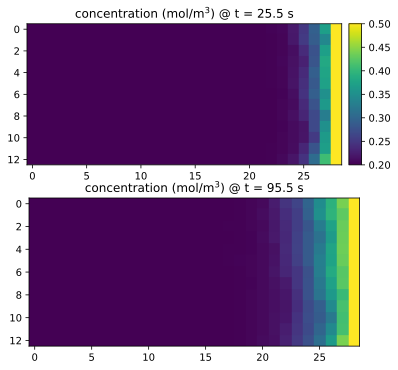

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Plot c(x,y) @ t=25.5 and t=95.5
fig, ax = plt.subplots(nrows=2, figsize=(6, 6))
im = ax[0].imshow(x(25.5).reshape(shape))
ax[0].set_title('concentration (mol/m$^3$) @ t = 25.5 s')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="4%", pad=0.1)
plt.colorbar(im, cax=cax)
im = ax[1].imshow(x(95.5).reshape(shape))
ax[1].set_title('concentration (mol/m$^3$) @ t = 95.5 s');